Notebook Dizini: e:\HOME\GitHub\DeponesLabs\turbo-tosec\notebooks\research
Eklenen Kaynak Yolu: e:\HOME\GitHub\DeponesLabs\turbo-tosec\src


e:\HOME\GitHub\DeponesLabs\turbo-tosec\src\turbo_tosec\utils.py:46: SyntaxWarning: invalid escape sequence '\/'
  print(f"{Console.OKCYAN}{':: HIGH-PERFORMANCE DATA INGESTION ENGINE ::'.center(cols)}{Console.ENDC}")


 PROFILE START: STAGED MODE
 Input: 4743 files
DB: Turbo Mode engaged (Low safety, High speed) | Mem: 75% | Threads: 1

[monitor] I/O Recording Started...
Calculating total size for progress bar...
📦 Strategy: StagedMode (Batch/ETL)
   Technique: XML -> Parquet (Stage) -> DuckDB
   Staging Area: profile_temp_chunks/
   Workers: 4


Generating Parquet: 100%|██████████| 388M/388M [01:17<00:00, 5.23MB/s, ROMs=1333246]



Loading Staged Data from profile_temp_chunks...
DuckDB: Bulk importing chunks from profile_temp_chunks/*.parquet ...
Bulk Import Success.
Import Complete.
[monitor] I/O Recording Stopped.

⏱️ Total Duration: 172.35 seconds
[monitor] I/O Recording Stopped.


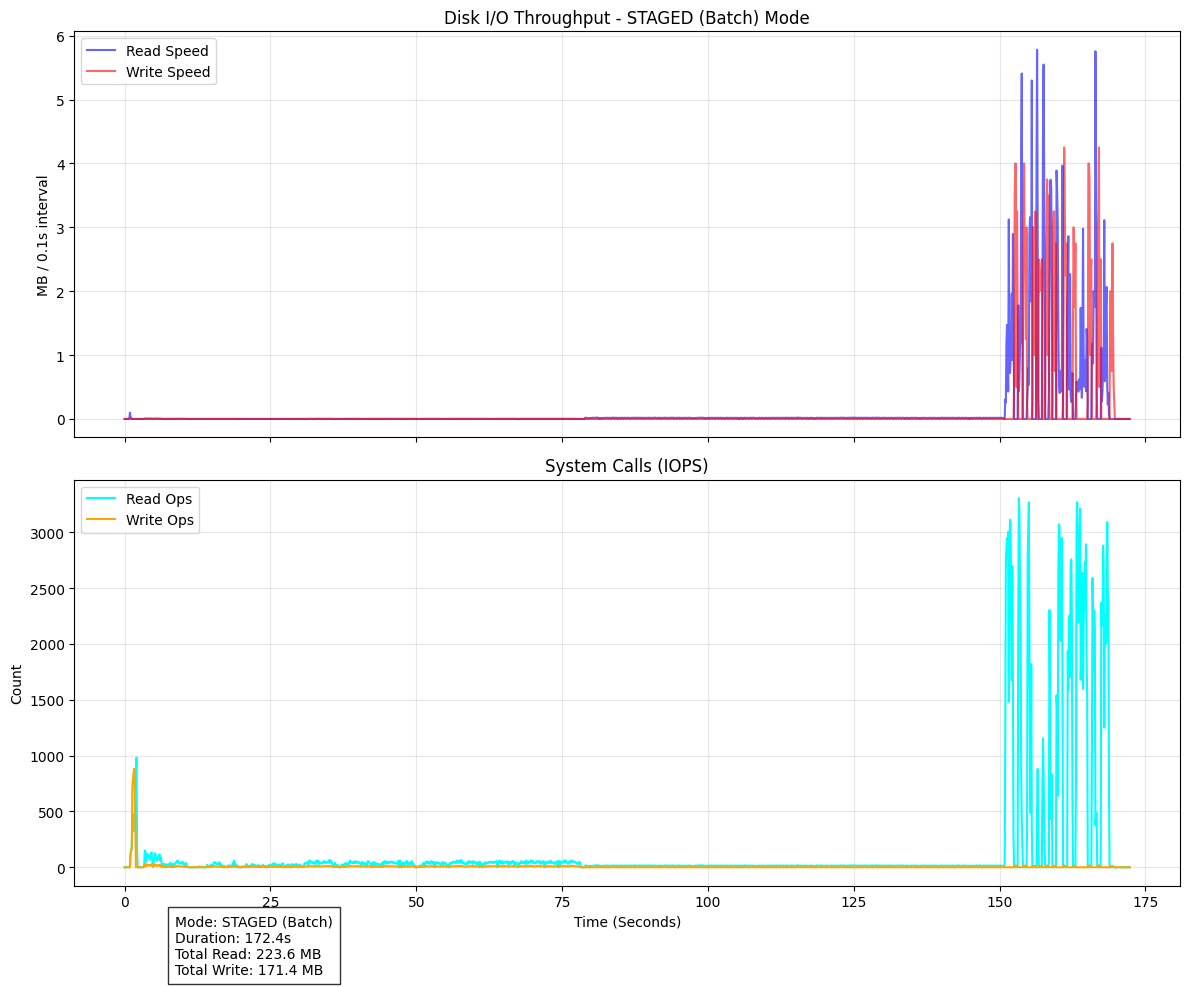

In [ ]:
"""
Turbo-TOSEC: I/O Profiling Analysis Tool
========================================
This script hooks into the system process to measure Disk I/O throughput
and IOPS (Input/Output Operations Per Second) while running the importer.

It supports the new architecture (ImportSession, DatabaseManager) and
allows comparing 'Staged Mode' vs 'Direct Mode'.
"""
import os
import sys
import shutil
import psutil
import time
import threading
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

current_dir = os.getcwd()
print(f"Notebook Dizini: {current_dir}")

if os.path.exists(os.path.join(current_dir, 'src')):
    src_path = os.path.abspath(os.path.join(current_dir, 'src'))
else:
    src_path = os.path.abspath(os.path.join(current_dir, '../..', 'src'))

if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Eklenen Kaynak Yolu: {src_path}")

from turbo_tosec.session import ImportSession
from turbo_tosec.utils import Console
from turbo_tosec.database import DatabaseManager, DBConfig


# Configuration (Edit here)
TEST_INPUT_PATH = r"E:\HOME\RetroVault\TOSEC_DATs\Extracted\TOSEC-v2025-03-13" 

OUTPUT_DB = "profile_test.duckdb"
TEMP_DIR = "profile_temp_chunks"

# Select Test Mode
USE_STAGED_MODE = True
USE_DIRECT_MODE = False  # If both are False, InMemory will work.
WORKER_COUNT = 4

# Monitor Class
class IOMonitor:
    """
    Background thread that monitors Process I/O counters using psutil.
    Acts as an oscilloscope for Disk usage.
    """
    def __init__(self, interval=0.1):
        
        self.interval = interval
        self.process = psutil.Process(os.getpid())
        self.running = False
        self.thread = None
        self.data = []

    def _monitor_loop(self):
        
        while self.running:
            try:
                # io_counters() returns: read_count, write_count, read_bytes, write_bytes
                io = self.process.io_counters()
            except Exception:
                break
            
            current_time = time.time()
            
            self.data.append({
                'timestamp': current_time,
                'read_count': io.read_count,
                'write_count': io.write_count,
                'read_bytes': io.read_bytes,
                'write_bytes': io.write_bytes
            })
            time.sleep(self.interval)

    def start(self):
        
        self.data = []
        self.running = True
        self.thread = threading.Thread(target=self._monitor_loop)
        self.thread.start()
        
        print(f"\n{Console.HEADER}[monitor] I/O Recording Started...{Console.ENDC}")

    def stop(self):
        
        self.running = False
        if self.thread:
            self.thread.join()
            
        print(f"{Console.HEADER}[monitor] I/O Recording Stopped.{Console.ENDC}")
        
        df = pd.DataFrame(self.data)
        if df.empty: return df
        
        # Relative Time
        df['time_rel'] = df['timestamp'] - df['timestamp'].iloc[0]
        
        # Calculate Deltas (Speed per interval)
        # We use `diff()` to find the difference between the previous measurement and the current one.
        df['read_mb'] = df['read_bytes'].diff().fillna(0) / (1024 * 1024)
        df['write_mb'] = df['write_bytes'].diff().fillna(0) / (1024 * 1024)
        
        # Ops per interval (IOPS approximate)
        df['ops_read'] = df['read_count'].diff().fillna(0)
        df['ops_write'] = df['write_count'].diff().fillna(0)
        
        return df


# Mock args (Simulate CLI Arguments)
@dataclass
class MockArgs:
    """Simulates the argparse Namespace object required by ImportSession."""
    input: str
    workers: int
    staged: bool
    direct: bool
    temp_dir: str
    batch_size: int = 1000
    db_memory: str = "75%"
    db_threads: int = 1
    resume: bool = False
    force_new: bool = True # Always wipe for profiling

def main():
    # 1. Setup Environment
    if os.path.exists(OUTPUT_DB):
        os.remove(OUTPUT_DB)
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)
        
    files_to_process = []
    if os.path.isdir(TEST_INPUT_PATH):
        for root, _, files in os.walk(TEST_INPUT_PATH):
            for f in files:
                if f.endswith(".dat"): files_to_process.append(os.path.join(root, f))
    else:
        files_to_process = [TEST_INPUT_PATH]

    if not files_to_process:
        print("No files found to test.")
        return

    args = MockArgs(
        input=TEST_INPUT_PATH,
        workers=WORKER_COUNT,
        staged=USE_STAGED_MODE,
        direct=USE_DIRECT_MODE,
        temp_dir=TEMP_DIR
    )
    
    # DB Config
    db_config = DBConfig(turbo=True, memory="75%", threads=1)
    
    monitor = IOMonitor(interval=0.1) # 100ms sampling
    
    print("="*60)
    print(f" PROFILE START: {'STAGED' if USE_STAGED_MODE else 'DIRECT'} MODE")
    print(f" Input: {len(files_to_process)} files")
    print("="*60)

    # 2. Execution Context
    with DatabaseManager(OUTPUT_DB, config=db_config) as db:
        db.wipe_database()
        
        session = ImportSession(args, db, files_to_process)
        
        monitor.start()
        start_t = time.time()
        
        try:
            session.run(files_to_process)
            
        except Exception as e:
            print(f"Error during profiling: {e}")
        finally:
            end_t = time.time()
            monitor.stop()

    # 3. Visualization
    duration = end_t - start_t
    print(f"\n⏱️ Total Duration: {duration:.2f} seconds")
    
    df_results = monitor.stop() # Ensure data is retrieved
    
    if not df_results.empty:
        plot_results(df_results, duration)
    else:
        print("No I/O data recorded.")

def plot_results(df, duration):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    mode_name = "STAGED" if USE_STAGED_MODE else "DIRECT (Stream)"
    
    # Plot 1: Throughput
    # Convert per-interval MB to MB/s (interval is approx 0.1s, so multiply by 10)
    # Actually, better to just show "MB per 100ms" or normalize properly.
    # Let's show instantaneous throughput roughly.
    
    ax[0].plot(df['time_rel'], df['read_mb'], label='Read Speed', color='blue', alpha=0.6)
    ax[0].plot(df['time_rel'], df['write_mb'], label='Write Speed', color='red', alpha=0.6)
    ax[0].set_title(f'Disk I/O Throughput - {mode_name} Mode')
    ax[0].set_ylabel('MB / 0.1s interval')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    # Plot 2: Operations
    ax[1].plot(df['time_rel'], df['ops_read'], label='Read Ops', color='cyan')
    ax[1].plot(df['time_rel'], df['ops_write'], label='Write Ops', color='orange')
    ax[1].set_title('System Calls (IOPS)')
    ax[1].set_xlabel('Time (Seconds)')
    ax[1].set_ylabel('Count')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    # Stats Text
    total_read = df['read_bytes'].max() / (1024*1024)
    total_write = df['write_bytes'].max() / (1024*1024)
    
    stats_text = (
        f"Mode: {mode_name}\n"
        f"Duration: {duration:.1f}s\n"
        f"Total Read: {total_read:.1f} MB\n"
        f"Total Write: {total_write:.1f} MB"
    )
    
    plt.figtext(0.15, 0.02, stats_text, fontsize=10, 
                bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

if __name__ == "__main__":
    
    main()